In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import json

from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
from halton_points import HaltonPoints
from function_Fm import *
from explicit_RK import *
from analytical_solution import *

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import gmres

import ray
import time

## Boundary

In [2]:
nf = 3#(2**1+1)**2
r = HaltonPoints(2, nf).haltonPoints()
fxl = r.copy()
fxl[:, 0] = 0
fxr = r.copy()
fxr[:, 0] = 1
fyu = r.copy()
fyu[:, 1] = 0
fyd = r.copy()
fyd[:, 1] = 1
Mb = np.vstack((fxl, fxr, fyu, fyd))

## Interior

In [3]:
poly_b = np.array([[-1, -1, 1], [1/2, 3/2, -1], [3/2, 1/8, -3/8]])
npnts = 12#(2**3+1)**2

uh = assembled_matrix(Mb=Mb, npnts=npnts, poly_b=poly_b, rbf='TPS')
uh.exact_solution = "2"
uh.nu = 0.01
uh.c = 1/4
uh.pols = 'Hermite'

domain = create_domain(uh.Mi, radius=0.35, c_y=0.5, c_x=0.5)

#unit_square
#circle_centre

uh.Mi, new_boundary = domain.setup(domain='unit_square', bound_points=12)
uh.Mb = np.vstack((uh.Mb, new_boundary))
uh.ni = uh.Mi.shape[0]
uh.nb = uh.Mb.shape[0]
X0 = uh.X_0()

In [4]:
boundary_points = pd.DataFrame(uh.Mb, columns=['x', 'y'])
boundary_points['Collocation'] = 'Boundary'

interior_points = pd.DataFrame(uh.Mi, columns=['x', 'y'])
interior_points['Collocation'] = 'Interior'

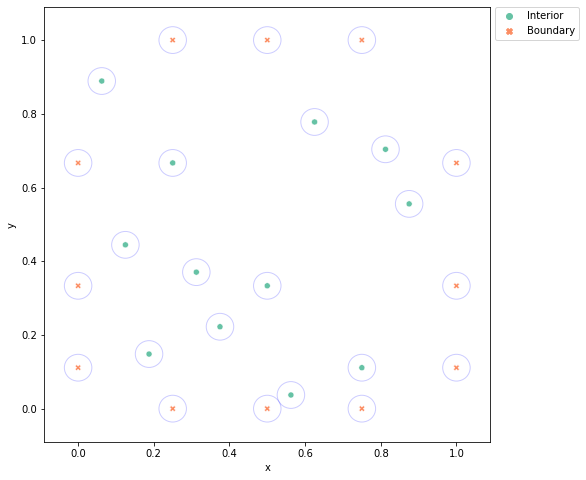

In [5]:
points = pd.concat([interior_points, boundary_points])

stable = stabillity(Mb, npnts)
qx = stable.qX()

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='x', y='y', data=points, hue='Collocation',
                style='Collocation', palette='Set2')
for hk in points[['x', 'y']].values:
    c = plt.Circle(hk, qx, fill=False, alpha=0.2, color='b')
    ax.add_patch(c)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.);

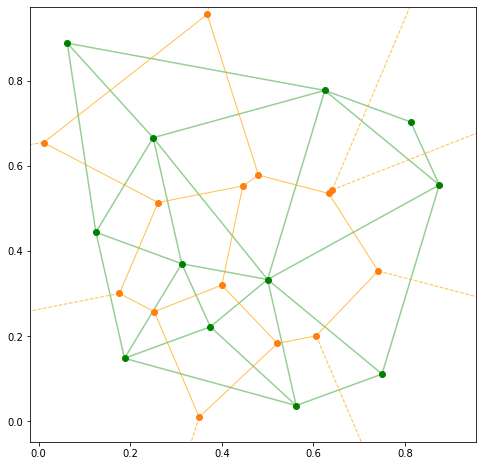

In [6]:
tri = Delaunay(uh.Mi)
vor = Voronoi(uh.Mi)

fig, axs = plt.subplots(figsize=(8, 8))
g = voronoi_plot_2d(vor, ax=axs, line_colors='orange', line_alpha=0.7)
plt.triplot(uh.Mi[:, 0], uh.Mi[:, 1], tri.simplices, alpha=0.5)
plt.plot(uh.Mi[:, 0], uh.Mi[:, 1], 'o', color='g')
plt.show()


In [7]:
print("Interior points: {:,.0f} \nBoundary points: {:,.0f} \nTotal points: {:,.0f}".format(uh.Mi.shape[0], uh.Mb.shape[0], uh.Mi.shape[0] + uh.Mb.shape[0]))

Interior points: 12 
Boundary points: 12 
Total points: 24


In [8]:
#uh.epsilon = 5.956
cond = np.linalg.cond(uh.ACaps())
det = np.linalg.det(uh.ACaps())
print('Condition number: {:,.0f} \nDeterminant: {:,.9f}'.format(cond, det))

Condition number: 9 
Determinant: -47,562.635429969


## Solve Matrix RK-Newthon

In [9]:
# Y = np.vstack((X0, X0))
# dt = 0.01
# uh.variables(X0, dt, Y)
#rr = uh.Rk(0.02)

In [10]:
# np.linalg.norm(Y, 'fro')

In [11]:
# for _ in range(50):
#     A, b = uh.inexact_Newthon(0.01)
#     Sp = np.linalg.inv(A).dot(b)
#     Y =  Y - Sp
#     uh.Y = Y
#     print(np.linalg.norm(Y, 'fro'))

In [12]:
#uh.Y

In [13]:
t0, te = 0, 1
N = 10
exp_RK = explicit_RungeKutta(Fm, X0, t0, te, N, uh)

In [14]:
# start_time = time.time()
# exp_RK.solve()
# time.time() - start_time

In [18]:
@ray.remote
def RK():
    exp_RK.solve()
    return exp_RK.solution

ray.init()
start_time = time.time()
exp_RK.solution = ray.get([RK.remote() for _ in range(1)])[0]
ray.shutdown()   
time.time() - start_time

2021-09-16 14:02:41,805	INFO services.py:1265 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=10392) t=0.1  error=1.5955%
(pid=10392) t=0.2  error=2.9225%
(pid=10392) t=0.3  error=3.9838%
(pid=10392) t=0.4  error=4.8066%
(pid=10392) t=0.5  error=5.4764%
(pid=10392) t=0.6  error=6.0691%
(pid=10392) t=0.7  error=6.5323%
(pid=10392) t=0.8  error=6.8792%
(pid=10392) t=0.9  error=7.0907%
(pid=10392) t=1.0  error=7.1980%


24.650377988815308

In [25]:
sol = exact_solution(uh.Mi, uh.nu)
n = exp_RK.solution.shape[0]
error = list()
for t in exp_RK.timegrid[1:]:
    ei = np.sqrt(np.linalg.norm(sol.u(t).round(6)-exp_RK.solution[int(t*N)].round(6))/n)
    error.append(ei)

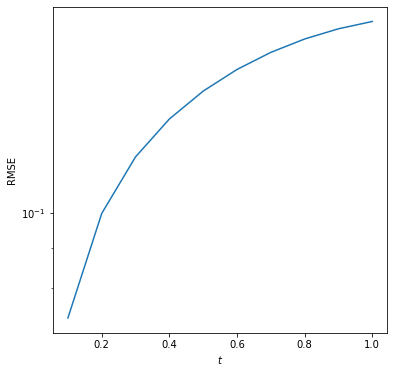

In [26]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(exp_RK.timegrid[1:], error)
plt.xlabel("$t$")
plt.ylabel("RMSE")
ax.set_yscale('log')
#ax.set_xscale('log')

In [27]:
sol_dict = {}
sol_dict['nu'] = uh.nu
sol_dict['RBF'] = uh.rbf
sol_dict['points'] = {'Interior': uh.Mi.tolist(), 'boundary': uh.Mb.tolist()}
uh_dict = dict()
for ti in range(exp_RK.solution.shape[0]):
    uh_dict[str(ti/N)] = exp_RK.solution[ti].tolist()
sol_dict['solution'] = uh_dict

In [ ]:
name_file = 'solution_' + uh.rbf + '_Mi_' + str(uh.ni) + '_Mb_' + str(uh.nb) + '_nu_' + str(uh.nu) + '_' + uh.pols +'.json'
with open(name_file, 'w') as outf:
    json.dump(sol_dict, outf)